## Reference:

Ye, H. (2019). Accurate image reconstruction in radio interferometry (Doctoral thesis). https://doi.org/10.17863/CAM.39448

Haoyang Ye, Stephen F Gull, Sze M Tan, Bojan Nikolic, Optimal gridding and degridding in radio interferometry imaging, Monthly Notices of the Royal Astronomical Society, Volume 491, Issue 1, January 2020, Pages 1146–1159, https://doi.org/10.1093/mnras/stz2970

Github: https://github.com/zoeye859/Imaging-Tutorial

In [60]:
%matplotlib notebook
import numpy as np
from scipy.optimize import leastsq, brent
from scipy.linalg import solve_triangular
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from time import process_time
from numpy.linalg import inv
np.set_printoptions(precision=6)
from Imaging_core_4original import *
from Gridding_core import *
import pickle
with open("min_misfit_gridding_7.pkl", "rb") as pp:
    opt_funcs = pickle.load(pp)

### 1. Read in the data

In [61]:
#########  Read in visibilities ##########
data = np.genfromtxt('out_barray_6d.csv', delimiter = ',')
jj = complex(0,1)
u_original = data.T[0]
v_original = data.T[1]
w_original = -data.T[2]
V_original = data.T[3] + jj*data.T[4]
n_uv = len(u_original)
uv_max = max(np.sqrt(u_original**2+v_original**2))
V,u,v,w = Visibility_minusw(V_original,u_original,v_original,w_original)

#### Determine the pixel size ####
X_size = 900 # image size on x-axis
Y_size = 900 # image size on y-axis
X_min = -np.pi/60. #You can change X_min and X_max in order to change the pixel size.
X_max = np.pi/60.
X = np.linspace(X_min, X_max, num=X_size+1)[0:X_size]
Y_min = -np.pi/60. #You can change Y_min and Y_max in order to change the pixel size.
Y_max = np.pi/60.
Y = np.linspace(Y_min,Y_max,num=Y_size+1)[0:Y_size]
pixel_resol_x = 180. * 60. * 60. * (X_max - X_min) / np.pi / X_size
pixel_resol_y = 180. * 60. * 60. * (Y_max - Y_min) / np.pi / Y_size
print ("The pixel size on x-axis is ", pixel_resol_x, " arcsec") 

The pixel size on x-axis is  23.999999999999996  arcsec


### 2. determine the number of w planes 

The number of w-stacks explained in (Offringa et al. 2014), $N_w$ is determined by:

$N_w \geq 2\pi(w_{\rm max} - w_{\rm min})\max_{l,m}(1-\sqrt{1-l^2-m^2})$



### 2. Determine w plane number Nw


In [62]:
def Wplanes_original_give(W, X_max, Y_max, w):
    """
      Give the w-stack number using the original W-Stacking method
    Args:
     """
    N_w = 460
    dw = (w.max() - w.min())/N_w
    w_values = [w.min() + dw * i for i in range(N_w)] # w vaule for each w-plane
    Nw_2R = len(w_values)
    print ("We will have", Nw_2R, "w-planes")   
    return Nw_2R, w_values, dw

In [63]:
W = 7
M, x0, h = opt_funcs[W].M, opt_funcs[W].x0, opt_funcs[W].h
Nw_2R, w_values, dw = Wplanes_original_give(W, X_max, Y_max, w)


We will have 460 w-planes


### 3 3D Gridding + Imaging + Correcting

To know more about gridding, you can refer to https://github.com/zoeye859/Imaging-Tutorial 
#### Assign the visibilities to their nearest w-planes

In [64]:
Nfft = 1800
im_size = 1800
ind = find_nearestw(w_values, w)
    

In [65]:
def grid_w_nearest(V, u, v, w, w_values, W, Nw_2R, idx):
    """
    Assign visibilities to their nearest w-planes
    Args:
        V (np.narray): visibility data
        u (np.narray): u of the (u,v,w) coordinates
        v (np.narray): v of the (u,v,w) coordinates
        w (np.narray): w of the (u,v,w) coordinates
        Nw_2R (int): number of w-planes used
        W (int): support width of the gridding function
        w_values (list): w values for all w-planes would be formed
        idx (list): the index of the nearest w plane that this w value would be assigned to
        dw (float): difference between two neighbouring w-planes
    """
    n_uv = len(V)
    bEAM = np.ones(n_uv)
    V_wgrid = np.zeros((Nw_2R,1),dtype = np.complex_).tolist()
    beam_wgrid = np.zeros((Nw_2R,1),dtype = np.complex_).tolist()
    u_wgrid = np.zeros((Nw_2R,1)).tolist()
    v_wgrid = np.zeros((Nw_2R,1)).tolist()
    t_start = process_time() 

    for k in range(n_uv):
        w_plane = idx[k]
        V_wgrid[w_plane] += [V[k]]
        u_wgrid[w_plane] += [u[k]]
        v_wgrid[w_plane] += [v[k]]
        beam_wgrid[w_plane] += [bEAM[k]]

    for i in range(Nw_2R):
        del(V_wgrid[i][0])
        del(u_wgrid[i][0])
        del(v_wgrid[i][0])
        del(beam_wgrid[i][0])

    t_stop = process_time()   
    print("Elapsed time during the w-gridding calculation in seconds:", t_stop-t_start)   
    return V_wgrid, u_wgrid, v_wgrid, beam_wgrid

In [66]:
V_wgrid, u_wgrid, v_wgrid, beam_wgrid = grid_w_nearest(V, u, v, w, w_values, W, Nw_2R, ind)

Elapsed time during the w-gridding calculation in seconds: 0.053537801999482326


#### Imaging

In [67]:
I_size = int(im_size*2*x0)
I_image = np.zeros((I_size,I_size),dtype = np.complex_)
B_image = np.zeros((I_size,I_size),dtype = np.complex_)

t2_start = process_time() 
for w_ind in range(Nw_2R):
    print ('Gridding the ', w_ind, 'th level facet out of ',Nw_2R,' w facets.\n')
    V_update = np.asarray(V_wgrid[w_ind])
    u_update = np.asarray(u_wgrid[w_ind])
    v_update = np.asarray(v_wgrid[w_ind])
    beam_update = np.asarray(beam_wgrid[w_ind])
    V_grid, B_grid = grid_uv(V_update, u_update, v_update, beam_update, W, im_size, X_max, X_min, Y_max, Y_min, h, M)
    print ('FFT the ', w_ind, 'th level facet out of ',Nw_2R,' w facets.\n')
    I_image += FFTnPShift(V_grid, w_values[w_ind], X, Y, im_size, x0)
    B_image += FFTnPShift(B_grid, w_values[w_ind], X, Y, im_size, x0)
    B_grid = np.zeros((im_size,im_size),dtype = np.complex_) 
    V_grid = np.zeros((im_size,im_size),dtype = np.complex_)
    
t2_stop = process_time()   
print("Elapsed time during imaging in seconds:", t2_stop-t2_start)  

Gridding the  0 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.1624154790006287
Elapsed time during the u/v gridding value calculation in seconds: 0.16605878900008975
FFT the  0 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  1 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.07691930999953911
Elapsed time during the u/v gridding value calculation in seconds: 0.07689345700055128
FFT the  1 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  2 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.08216144099969824
Elapsed time during the u/v gridding value calculation in seconds: 0.08234180500039656
FFT the  2 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gr

FFT the  24 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  25 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.1079593409995141
Elapsed time during the u/v gridding value calculation in seconds: 0.11066246500013222
FFT the  25 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  26 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.10394148399973346
Elapsed time during the u/v gridding value calculation in seconds: 0.10692554500019469
FFT the  26 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  27 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.09784318299989536
Elapsed time during the u/v gridding value calculation in seconds: 0.09775039199939

FFT the  49 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  50 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.10212191799928405
Elapsed time during the u/v gridding value calculation in seconds: 0.10474480199991376
FFT the  50 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  51 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.10332331099925796
Elapsed time during the u/v gridding value calculation in seconds: 0.10688613500042266
FFT the  51 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  52 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.08681163699930039
Elapsed time during the u/v gridding value calculation in seconds: 0.0866846720000

FFT the  74 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  75 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.06960500900004263
Elapsed time during the u/v gridding value calculation in seconds: 0.06972218700047961
FFT the  75 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  76 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.07072538299962616
Elapsed time during the u/v gridding value calculation in seconds: 0.07090052099920285
FFT the  76 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  77 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.07565812700067909
Elapsed time during the u/v gridding value calculation in seconds: 0.0758968820000

FFT the  99 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  100 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.04757764300029521
Elapsed time during the u/v gridding value calculation in seconds: 0.047671059999629506
FFT the  100 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  101 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.05648200799987535
Elapsed time during the u/v gridding value calculation in seconds: 0.05624634800005879
FFT the  101 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  102 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.05686808600057702
Elapsed time during the u/v gridding value calculation in seconds: 0.0569382

Gridding the  124 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.04227793600057339
Elapsed time during the u/v gridding value calculation in seconds: 0.041836886999590206
FFT the  124 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  125 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.04172936000031768
Elapsed time during the u/v gridding value calculation in seconds: 0.04195212300055573
FFT the  125 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  126 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.07172540699957608
Elapsed time during the u/v gridding value calculation in seconds: 0.07115898999927595
FFT the  126 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phase

Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  149 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.03818251699976827
Elapsed time during the u/v gridding value calculation in seconds: 0.03852265399928001
FFT the  149 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  150 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.02263909799967223
Elapsed time during the u/v gridding value calculation in seconds: 0.02286965099938243
FFT the  150 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  151 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.01689677899958042
Elapsed time during the u/v gridding value calculation in seconds: 0.016413391000241973
FFT the  151 th level facet out of  460  w facets.

Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  174 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.014686958000311279
Elapsed time during the u/v gridding value calculation in seconds: 0.014849074999801815
FFT the  174 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  175 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.024892540000109875
Elapsed time during the u/v gridding value calculation in seconds: 0.025021465999998327
FFT the  175 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  176 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.033884816999488976
Elapsed time during the u/v gridding value calculation in seconds: 0.03389132799929939
FFT the  176 th level facet out of  460  w fac

Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  199 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.03261017500062735
Elapsed time during the u/v gridding value calculation in seconds: 0.02560783100034314
FFT the  199 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  200 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.02512111900068703
Elapsed time during the u/v gridding value calculation in seconds: 0.025941984999917622
FFT the  200 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  201 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.02093982699989283
Elapsed time during the u/v gridding value calculation in seconds: 0.019813107999652857
FFT the  201 th level facet out of  460  w facets

FFTing...
Phaseshifting...
Gridding the  224 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.01393100199948094
Elapsed time during the u/v gridding value calculation in seconds: 0.014869608000481094
FFT the  224 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  225 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.021735313000135648
Elapsed time during the u/v gridding value calculation in seconds: 0.021544483000070613
FFT the  225 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  226 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.011836341999696742
Elapsed time during the u/v gridding value calculation in seconds: 0.01419947999966098
FFT the  226 th level facet out of  460  w facets.

FFTing...
Ph

Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  249 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.010052951999568904
Elapsed time during the u/v gridding value calculation in seconds: 0.010195372000453062
FFT the  249 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  250 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.009068656999261293
Elapsed time during the u/v gridding value calculation in seconds: 0.009281455999371246
FFT the  250 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  251 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.00812110999959259
Elapsed time during the u/v gridding value calculation in seconds: 0.008315215999573411
FFT the  251 th level facet out of  460  w fac

FFTing...
Phaseshifting...
Gridding the  274 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.0039040980000208947
Elapsed time during the u/v gridding value calculation in seconds: 0.00407803799953399
FFT the  274 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  275 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.0030150279999361373
Elapsed time during the u/v gridding value calculation in seconds: 0.0031823829995119013
FFT the  275 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  276 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.007245484000122815
Elapsed time during the u/v gridding value calculation in seconds: 0.00740011699963361
FFT the  276 th level facet out of  460  w facets.

FFTing...

FFTing...
Phaseshifting...
Gridding the  299 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.011364627000148175
Elapsed time during the u/v gridding value calculation in seconds: 0.011330108000038308
FFT the  299 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  300 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.008416701999522047
Elapsed time during the u/v gridding value calculation in seconds: 0.008768856999267882
FFT the  300 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  301 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.010307389000445255
Elapsed time during the u/v gridding value calculation in seconds: 0.010395250999863492
FFT the  301 th level facet out of  460  w facets.

FFTing...


FFTing...
Phaseshifting...
Gridding the  324 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.0017589050003152806
Elapsed time during the u/v gridding value calculation in seconds: 0.0020278149995647254
FFT the  324 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  325 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.002960178000648739
Elapsed time during the u/v gridding value calculation in seconds: 0.003154469000037352
FFT the  325 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  326 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.008477833999677387
Elapsed time during the u/v gridding value calculation in seconds: 0.008653564999804075
FFT the  326 th level facet out of  460  w facets.

FFTing..

Gridding the  348 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 2.8632999601541087e-05
Elapsed time during the u/v gridding value calculation in seconds: 8.936000085668638e-06
FFT the  348 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  349 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.0040230960003100336
Elapsed time during the u/v gridding value calculation in seconds: 0.004118316000131017
FFT the  349 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  350 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 2.549700002418831e-05
Elapsed time during the u/v gridding value calculation in seconds: 8.575999345339369e-06
FFT the  350 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTi

FFTing...
Phaseshifting...
Gridding the  373 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.0011431459988671122
Elapsed time during the u/v gridding value calculation in seconds: 0.0013470710000547115
FFT the  373 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  374 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.0023770589996274794
Elapsed time during the u/v gridding value calculation in seconds: 0.002529748000597465
FFT the  374 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  375 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.0023675709999224637
Elapsed time during the u/v gridding value calculation in seconds: 0.002563437999924645
FFT the  375 th level facet out of  460  w facets.

FFTing

Gridding the  397 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 2.9123000786057673e-05
Elapsed time during the u/v gridding value calculation in seconds: 1.0208999810856767e-05
FFT the  397 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  398 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.0006863689995952882
Elapsed time during the u/v gridding value calculation in seconds: 0.0007208180013549281
FFT the  398 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  399 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.0020721199998661177
Elapsed time during the u/v gridding value calculation in seconds: 0.0022956680004426744
FFT the  399 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FF

FFTing...
Phaseshifting...
Gridding the  422 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 2.71400003839517e-05
Elapsed time during the u/v gridding value calculation in seconds: 9.606999810785055e-06
FFT the  422 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  423 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 2.7469999622553587e-05
Elapsed time during the u/v gridding value calculation in seconds: 9.727998985908926e-06
FFT the  423 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  424 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 3.54349995177472e-05
Elapsed time during the u/v gridding value calculation in seconds: 1.1791998986154795e-05
FFT the  424 th level facet out of  460  w facets.

FFTi

FFTing...
Phaseshifting...
Gridding the  446 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 2.6287998480256647e-05
Elapsed time during the u/v gridding value calculation in seconds: 8.525999874109402e-06
FFT the  446 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  447 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 2.613800097606145e-05
Elapsed time during the u/v gridding value calculation in seconds: 8.666000212542713e-06
FFT the  447 th level facet out of  460  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  448 th level facet out of  460  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 2.5968000045395456e-05
Elapsed time during the u/v gridding value calculation in seconds: 9.426999895367771e-06
FFT the  448 th level facet out of  460  w facets.

FF

#### Rescale and have a look

In [68]:
I_image_now = image_rescale(I_image,im_size, n_uv)
B_image_now = image_rescale(B_image,im_size, n_uv)
plt.figure()
plt.imshow(np.rot90(I_image_now.real,1), origin = 'lower')
plt.xlabel('Image Coordinates X')
plt.ylabel('Image Coordinates Y')
plt.show()
B_image_now[450,450]

<IPython.core.display.Javascript object>

(1.0000000016137804+0j)

#### Correcting functions h(x)h(y) on x and y axis

#### W= 7, x0 = 0.25

In [69]:
Nfft = 600
# Use these for calculating gridding correction on the FFT grid
M = 32
I_xycorrected = xy_correct(I_image_now, opt_funcs[W], im_size, x0=0.25)
B_xycorrected = xy_correct(B_image_now, opt_funcs[W], im_size, x0=0.25)

In [70]:
plt.figure()
plt.imshow(np.rot90(I_xycorrected.real,1), origin = 'lower')
plt.xlabel('Image Coordinates X')
plt.ylabel('Image Coordinates Y')
plt.show()
B_xycorrected[450,450]

<IPython.core.display.Javascript object>

(1.000000001613783+0j)

#### Correcting function on z axis

In [71]:
def C(u):
    return 1

In [72]:
def z_correct_nearest(X_min, X_max, Y_min, Y_max, dw, im_size, W, C, x0=0.25):
    """
    Return:
        Cor_gridz (np.narray): correcting function on z-axis using other gridding function, such as spheroidal functrion
    """ 
    M = 32
    nu, x = make_evaluation_grids(W, M, im_size/2)
    grid_correct = np.sinc(x)
    grid_correction = 1/grid_correct
    h_map = np.zeros(im_size, dtype=float)
    h_map[im_size//2:] = grid_correction[:im_size//2]
    h_map[:im_size//2] = grid_correction[:0:-1]
    print (h_map)
    xrange = X_max - X_min
    yrange = Y_max - Y_min
    ny = im_size
    nx = im_size
    fmap = np.zeros((nx,ny))
    for i in range(ny):
        yy = 2.*yrange*(i - ny/2)/ny
        for j in range(nx):
            xx = 2.*xrange*(j - nx/2)/nx
            if (xx*xx + yy*yy > 0.99999999) or (abs(xx) > 0.55*xrange) or (abs(yy) > 0.55*yrange):
                z = 0.
            else:
                z = dw*(1. - np.sqrt(1. - xx*xx - yy*yy))
                ind0 = (int)(z*nx + nx/2.)
                xin = (float) (z*nx + nx/2.) - ind0
                fmap[i,j] = int5(h_map,ind0,xin,1)
    Cor_gridz = image_crop(fmap, im_size, x0)
    return Cor_gridz

In [73]:
Cor_gridz = z_correct_nearest(X_min, X_max, Y_min, Y_max, dw, im_size, 1, C, x0=0.25)
I_zcorrected = z_correct(I_xycorrected, Cor_gridz, im_size, x0=0.25)
B_zcorrected = z_correct(B_xycorrected, Cor_gridz, im_size, x0=0.25)

[1.570796 1.569053 1.567315 ... 1.565582 1.567315 1.569053]


In [74]:
plt.figure()
plt.imshow(np.rot90(Cor_gridz,1), origin = 'lower')
plt.colorbar()
plt.xlabel('Image Coordinates X')
plt.ylabel('Image Coordinates Y')
plt.show()


<IPython.core.display.Javascript object>

### 4 DFT and FFT dirty image difference

In [75]:
I_DFT = np.loadtxt('I_DFT_900_out6db.csv', delimiter = ',')

In [76]:
I_dif = I_DFT - I_xycorrected.real
plt.figure()
plt.imshow(np.rot90(I_dif,1), origin = 'lower')
plt.colorbar()
plt.xlabel('Image Coordinates X')
plt.ylabel('Image Coordinates Y')
plt.show()
rms = RMS(I_dif, im_size, 0.5, x0=0.25)
print (rms)

<IPython.core.display.Javascript object>

0.00044281190026163893


In [77]:
RMS(I_dif, im_size, 0.5, x0=0.25)

0.00044281190026163893

In [78]:
I_dif_r = I_rotation(900,I_dif)
fig1, ax1 = plt.subplots()

img1 = ax1.imshow(I_dif_r, cmap='binary', origin = 'lower')
# Where we want the ticks, in pixel locations
ticks = np.array((0,150,300,450,600,750,900))
ticklabelsx = ["{:6.1f}$^\circ$".format(i) for i in (450-ticks)*24/3600.]
ticklabelsy = ["{:6.1f}$^\circ$".format(i) for i in (ticks-450)*24/3600.]
ax1.set_xticks(ticks)
ax1.set_xticklabels(ticklabelsx)
ax1.set_yticks(ticks)
ax1.set_yticklabels(ticklabelsy)
ax1.set_title(r'Image misfit')
ax1.set_xlabel('Right Ascension (J2000)')
ax1.set_ylabel('Declination (J2000)')
fig1.colorbar(img1)
fig1.show()
#fig1.savefig('Misfit_simul_W7.png', dpi=300)

<IPython.core.display.Javascript object>

In [79]:
I_zcorrected_r = I_rotation(900,I_zcorrected)

fig2, ax2 = plt.subplots()
img2 = ax2.imshow(I_zcorrected_r, cmap='binary', origin = 'lower')
# Where we want the ticks, in pixel locations
ax2.set_xticks(ticks)
ax2.set_xticklabels(ticklabelsx)
ax2.set_yticks(ticks)
ax2.set_yticklabels(ticklabelsy)
ax2.set_title(r'Dirty image by improved W-Stacking')
ax2.set_xlabel('Right Ascension (J2000)')
ax2.set_ylabel('Declination (J2000)')
fig2.colorbar(img2)
fig2.show()
#fig2.savefig('FFT_W7.png', dpi=300)

/home/hye/Wide-field-Nfacet/Imaging_core_4original.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  I_r[size-1-i,j] = I[j,i]


<IPython.core.display.Javascript object>

### Primary Beam correction

In [80]:
def pb_cor(pbcor,size,I):
    """
    Primary beam correction
    """
    for i in range(size):
        for j in range(size):
            I[i,j] = I[i,j]/pbcor[i,j]
    return I

In [81]:
from astropy.io import fits
fits_file = 'out_1800.flux.fits'
hdu_list = fits.open(fits_file)
pbcor = hdu_list[0].data
hdu_list.close()
pbcor = pbcor.reshape((1800,1800))
pbcor = pbcor[450:1350,450:1350]

I_zcorrected_r = I_rotation(900,I_zcorrected)
## primary beam correction
I_zcorrected_r_pbcor = pb_cor(pbcor,900,I_zcorrected_r)
fig3, ax3 = plt.subplots()

img3 = ax3.imshow(I_zcorrected_r_pbcor, cmap='binary', origin = 'lower')
# Where we want the ticks, in pixel locations
ax3.set_xticks(ticks)
ax3.set_xticklabels(ticklabelsx)
ax3.set_yticks(ticks)
ax3.set_yticklabels(ticklabelsy)
ax3.set_title(r'Dirty image by improved W-Stacking method')
ax3.set_xlabel('Right Ascension (J2000)')
ax3.set_ylabel('Declination (J2000)')
fig3.colorbar(img3)
fig3.show()
#fig3.savefig('FFT_W7_pbcor.png', dpi=300)

<IPython.core.display.Javascript object>

In [82]:
## primary beam correction
I_dif_r_pbcor = pb_cor(pbcor,900,I_dif_r)
fig4, ax4 = plt.subplots()

img4 = ax4.imshow(I_dif_r_pbcor, cmap='binary', origin = 'lower')
# Where we want the ticks, in pixel locations
ax4.set_xticks(ticks)
ax4.set_xticklabels(ticklabelsx)
ax4.set_yticks(ticks)
ax4.set_yticklabels(ticklabelsy)
ax4.set_title(r'Image misfit')
ax4.set_xlabel('Right Ascension (J2000)')
ax4.set_ylabel('Declination (J2000)')
fig4.colorbar(img4)
fig4.show()
#fig4.savefig('Misfit_simul_W7_pbcor.png', dpi=300)

<IPython.core.display.Javascript object>

In [83]:
RMS(I_dif_r_pbcor, im_size, 0.5, x0=0.25)

0.0005276893171073472

In [87]:
np.savetxt('Difference_470planes.csv',I_dif_r_pbcor, delimiter=',')

<IPython.core.display.Javascript object>


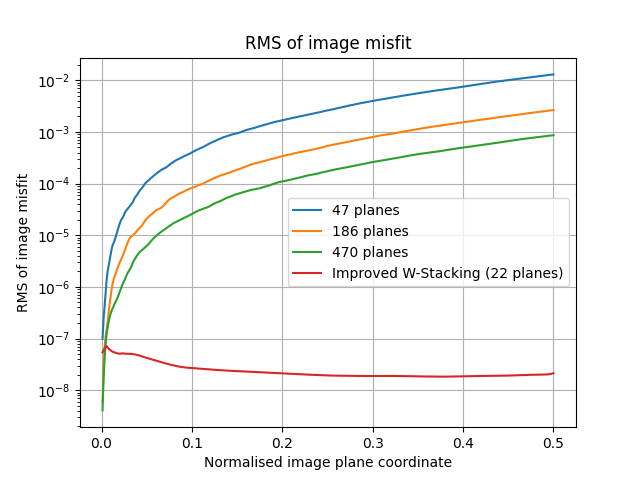

In [91]:
I_diff_47planes = np.loadtxt('Difference_47planes.csv', delimiter = ',')
I_diff_186planes = np.loadtxt('Difference_186planes.csv', delimiter = ',')
I_diff_470planes = np.loadtxt('Difference_470planes.csv', delimiter = ',')
I_diff = np.loadtxt('Difference_improved.csv', delimiter = ',')
rms47 = np.zeros(450)
rms186 = np.zeros(450)
rms470 = np.zeros(450)
rms = np.zeros(450)
j = 0
for i in np.arange(0,450,1):
    rms47[j] = np.sqrt(np.mean(I_diff_47planes[i:(900-i),i:(900-i)]**2))
    rms186[j] = np.sqrt(np.mean(I_diff_186planes[i:(900-i),i:(900-i)]**2))
    rms470[j] = np.sqrt(np.mean(I_diff_470planes[i:(900-i),i:(900-i)]**2))
    rms[j] = np.sqrt(np.mean(I_diff[i:(900-i),i:(900-i)]**2))
    j=j+1

plt.figure()
i = np.arange(0,450,1)
x = (450-i)/450/2
plt.semilogy(x,rms47, label = '47 planes')
plt.semilogy(x,rms186, label = '186 planes')
plt.semilogy(x,rms470, label = '470 planes')
plt.semilogy(x,rms, label = 'Improved W-Stacking (22 planes)')
#plt.ylim(1e-7,1e-1)
plt.title(r'RMS of image misfit')
plt.xlabel('Normalised image plane coordinate')
plt.ylabel('RMS of image misfit')

plt.grid()
plt.legend()
plt.show()
plt.savefig('RMS_comparison.png', dpi=300)

<IPython.core.display.Javascript object>


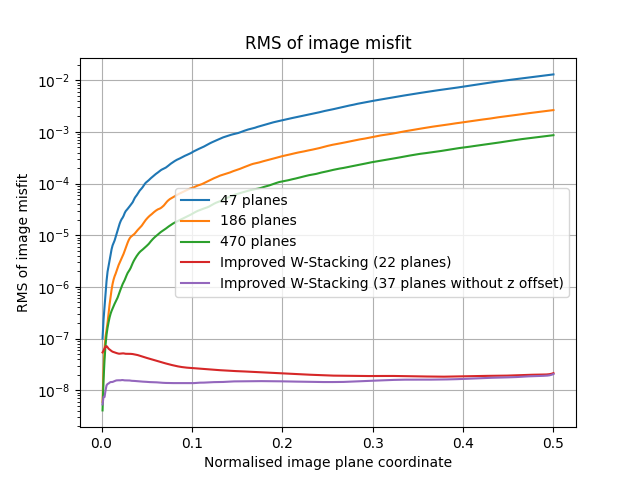

In [94]:
I_diff_47planes = np.loadtxt('Difference_47planes.csv', delimiter = ',')
I_diff_186planes = np.loadtxt('Difference_186planes.csv', delimiter = ',')
I_diff_470planes = np.loadtxt('Difference_470planes.csv', delimiter = ',')
I_diff_withoutoffset = np.loadtxt('Difference_improved_withoutoffset.csv', delimiter = ',')
I_diff = np.loadtxt('Difference_improved.csv', delimiter = ',')
rms47 = np.zeros(450)
rms186 = np.zeros(450)
rms470 = np.zeros(450)
rms = np.zeros(450)
rms_withoutoffset = np.zeros(450)
j = 0
for i in np.arange(0,450,1):
    rms47[j] = np.sqrt(np.mean(I_diff_47planes[i:(900-i),i:(900-i)]**2))
    rms186[j] = np.sqrt(np.mean(I_diff_186planes[i:(900-i),i:(900-i)]**2))
    rms470[j] = np.sqrt(np.mean(I_diff_470planes[i:(900-i),i:(900-i)]**2))
    rms[j] = np.sqrt(np.mean(I_diff[i:(900-i),i:(900-i)]**2))
    rms_withoutoffset[j] = np.sqrt(np.mean(I_diff_withoutoffset[i:(900-i),i:(900-i)]**2))                            
    j=j+1

plt.figure()
i = np.arange(0,450,1)
x = (450-i)/450/2
plt.semilogy(x,rms47, label = '47 planes')
plt.semilogy(x,rms186, label = '186 planes')
plt.semilogy(x,rms470, label = '470 planes')
plt.semilogy(x,rms, label = 'Improved W-Stacking (22 planes)')
plt.semilogy(x,rms_withoutoffset, label = 'Improved W-Stacking (37 planes without z offset)')                       
#plt.ylim(1e-7,1e-1)
plt.title(r'RMS of image misfit')
plt.xlabel('Normalised image plane coordinate')
plt.ylabel('RMS of image misfit')

plt.grid()
plt.legend()
plt.show()
plt.savefig('RMS_comparison_2.png', dpi=300)

<IPython.core.display.Javascript object>


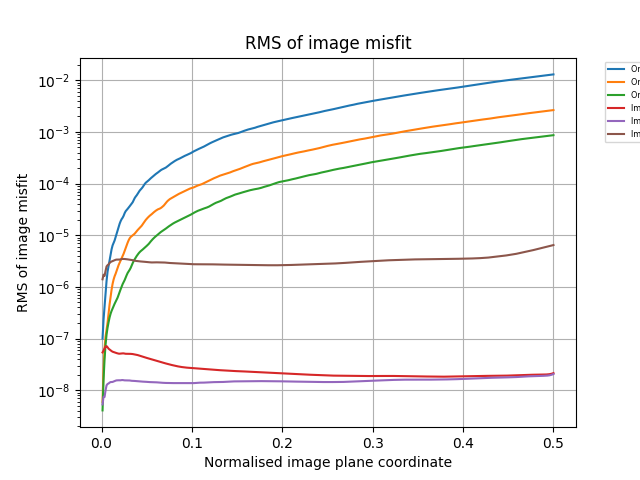

In [97]:
I_diff_47planes = np.loadtxt('Difference_47planes.csv', delimiter = ',')
I_diff_186planes = np.loadtxt('Difference_186planes.csv', delimiter = ',')
I_diff_470planes = np.loadtxt('Difference_470planes.csv', delimiter = ',')
I_diff_withoutoffset = np.loadtxt('Difference_improved_withoutoffset.csv', delimiter = ',')
I_diff_spheroidal = np.loadtxt('Difference_spheroidal.csv', delimiter = ',')
I_diff = np.loadtxt('Difference_improved.csv', delimiter = ',')
rms47 = np.zeros(450)
rms186 = np.zeros(450)
rms470 = np.zeros(450)
rms = np.zeros(450)
rms_withoutoffset = np.zeros(450)
rms_spheroidal = np.zeros(450)
j = 0
for i in np.arange(0,450,1):
    rms47[j] = np.sqrt(np.mean(I_diff_47planes[i:(900-i),i:(900-i)]**2))
    rms186[j] = np.sqrt(np.mean(I_diff_186planes[i:(900-i),i:(900-i)]**2))
    rms470[j] = np.sqrt(np.mean(I_diff_470planes[i:(900-i),i:(900-i)]**2))
    rms[j] = np.sqrt(np.mean(I_diff[i:(900-i),i:(900-i)]**2))
    rms_withoutoffset[j] = np.sqrt(np.mean(I_diff_withoutoffset[i:(900-i),i:(900-i)]**2)) 
    rms_spheroidal[j] = np.sqrt(np.mean(I_diff_spheroidal[i:(900-i),i:(900-i)]**2)) 
    j=j+1

plt.figure()
i = np.arange(0,450,1)
x = (450-i)/450/2
plt.semilogy(x,rms47, label = 'Original W-Stacking (47 planes)')
plt.semilogy(x,rms186, label = 'Original W-Stacking (186 planes)')
plt.semilogy(x,rms470, label = 'Original W-Stacking (470 planes)')
plt.semilogy(x,rms, label = 'Improved W-Stacking (22 planes)')
plt.semilogy(x,rms_withoutoffset, label = 'Improved W-Stacking (37 planes without z offset)')                       
plt.semilogy(x,rms_spheroidal, label = 'Improved W-Stacking using spheroidal function (37 planes without z offset)')                       

#plt.ylim(1e-7,1e-1)
plt.title(r'RMS of image misfit')
plt.xlabel('Normalised image plane coordinate')
plt.ylabel('RMS of image misfit')

plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='xx-small')
plt.show()
plt.savefig('RMS_comparison_3.png', bbox_inches='tight', dpi=300)